In [ ]:
!pip install pytorch_lightning
!pip install tensorboardX
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 651.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [ ]:
import pandas as pd
import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

from tqdm.autonotebook import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

import typing as tp
import faiss
from sklearn.metrics.pairwise import euclidean_distances
from functools import partial
import shutil

np.random.seed(31337)

In [ ]:
data =  pd.read_csv("/gdrive/MyDrive/RecSys_Data/1600kfeedbacks.csv")
track_metadata = pd.read_json("/gdrive/MyDrive/RecSys_Data/tracks.json", lines=True).drop_duplicates(subset=["track"])

In [ ]:
user_mapping = dict(zip(data['user'].unique(), range(len(data['user'].unique()))))

In [ ]:
data['user'] = data['user'].map(user_mapping).fillna(-1).astype(int)


In [ ]:
positives = data[data["time"] > 0.75].copy()

track_counts = positives.groupby("track").size()
tracks = set(track_counts[track_counts >= 3].index.values)

data_filt = positives[positives["track"].isin(tracks)]

len(data_filt), len(tracks)

(259903, 26019)

In [ ]:
len(data["user"].unique())

10000

In [ ]:
interactions = pd.pivot_table(data_filt, values="time", index="user", columns="track").fillna(0)

print("Interactions matrix: \nshape=" + str(interactions.shape))
print("Sparsity=" + str((interactions != 0).values.sum() / interactions.size))

Interactions matrix: 
shape=(10000, 26019)
Sparsity=0.000998896959913909


Отберем фичи айтемов: популярность и жанр

In [ ]:
track_metadata.shape, track_metadata.isnull().sum(axis = 0)

((50000, 5),
 artist    0
 title     0
 genre     0
 pop       0
 track     0
 dtype: int64)

In [ ]:
track_metadata

,artist,title,genre,pop,track
0,Harmonia,Sehr kosmisch,Pop_Rock,65688,7
1,Björk,Undo,Unk,57660,0
2,Dwight Yoakam,You're The One,Country,55035,2
3,Florence + The Machine,Dog Days Are Over (Radio Edit),Unk,52773,1
4,Kings Of Leon,Revelry,Pop_Rock,48290,15
...,...,...,...,...,...
49995,New Found Glory,Tennessee (Arrested Development cover) (Album),Unk,55,40519
49996,De Kreuners,Door Jou,Easy_Listening,55,22019
49997,Tears For Fears,Ashes To Ashes,Unk,55,49287
49998,Railroad Earth,Mourning Flies,Pop_Rock,55,49699


In [ ]:
track_metadata = track_metadata.fillna(value={'genre': 'Unk'})

In [ ]:
dummy_features = pd.get_dummies(track_metadata[["genre"]])
item_features = pd.concat([track_metadata[["track", "pop"]], dummy_features], axis=1).set_index("track", drop=True)
item_features['pop'] = np.log(item_features['pop'])
item_features.shape

(50000, 23)

In [ ]:
item_features

,pop,genre_Avant_Garde,genre_Blues,genre_Children,genre_Classical,genre_Comedy_Spoken,genre_Country,genre_Easy_Listening,genre_Electronic,genre_Folk,...,genre_Latin,genre_New Age,genre_Pop_Rock,genre_Rap,genre_Reggae,genre_Religious,genre_RnB,genre_Stage,genre_Unk,genre_Vocal
track,,,,,,,,,,,,,,,,,,,,,
7,11.092672,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
0,10.962319,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,10.915725,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.873755,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15,10.784980,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40519,4.007333,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
22019,4.007333,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
49287,4.007333,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Соберем трейн сразу по тройкам объектов:

uid, iid_pos, iid_neg

* pos - позитивный айтем из сессиии
* neg - случайный айтем из всего каталога

In [ ]:
triplets = data_filt[["user", "track"]].rename(columns={"track": "track_pos"})

In [ ]:
triplets = data_filt[["user", "track"]].rename(columns={"track": "track_pos"})
NUM_NEGATIVE_SAMPLES = 10
triplets =  pd.concat([triplets] * NUM_NEGATIVE_SAMPLES).sort_index().reset_index(drop=True)
triplets["track_neg"] = np.random.choice(range(50000), len(triplets))

Разобьем тройки на train, val, test

In [ ]:
rdm = np.random.random(len(triplets))
train_data = triplets[rdm < 0.9]
val_data = triplets[rdm >= 0.9]
test_data = []

len(train_data), len(val_data), len(test_data)

(2338743, 260287, 0)

In [ ]:
item_features.shape, interactions.shape

((50000, 23), (10000, 26019))

In [ ]:
from random import shuffle

def pad_with_specific_value(lst, size, val):
    lst = list(set(lst))
    shuffle(lst)
    lst = lst[:size]
    return np.pad(lst, (0, size - len(lst)), 'constant', constant_values=(val))

padded_users = triplets.groupby("user").apply(lambda x: (
    pad_with_specific_value(x['track_pos'].tolist(), 30, 50000).tolist()
))

padded_users = padded_users.reindex(range(10000), fill_value=[50000] * 30)
padded_users = np.stack(padded_users.values)

In [ ]:
padded_users

array([[11890,   472, 10112, ..., 50000, 50000, 50000],
       [ 9462, 44806, 25158, ..., 50000, 50000, 50000],
       [ 3776, 20128,  8158, ...,  8266, 24455, 12353],
       ...,
       [  952,  4081,  6793, ..., 50000, 50000, 50000],
       [13735,  4273,  7544, ..., 50000, 50000, 50000],
       [35469, 25018,   276, ..., 50000, 50000, 50000]])

In [ ]:
len(triplets["user"].unique())

10000

### Создаем датасет для оубчения

Он должен возвращать 3 тензора:

*   user_feaures
*   item_features_pos
*   item_features_neg



In [ ]:
class DSSMData(pl.LightningDataModule):
  def __init__(self, train_triplets, val_triplets, test_triplets, item_features, padded_users):
      super().__init__()
      self.train_triplets = train_triplets
      self.val_triplets = val_triplets
      self.test_triplets = test_triplets
      self.item_features = item_features
      self.padded_users = padded_users

  def _collect_data(self, triplets):
      users = triplets["user"].values
      positives = triplets["track_pos"].values
      negatives = triplets["track_neg"].values

      # Wipe out positive interacted tracks from user listen history
      listened_tracks = self.padded_users[users]
      listened_tracks[listened_tracks == positives.reshape(-1, 1)] = 50000
      listened_tracks[listened_tracks == negatives.reshape(-1, 1)] = 50000

      return td.TensorDataset(
            torch.from_numpy(listened_tracks).long(),
            torch.from_numpy(item_features.loc[positives].values).double(),
            torch.from_numpy(item_features.loc[negatives].values).double()
      )

  def prepare_data(self, stage=None):
      if stage == "fit" or stage is None:
        self.train_dataset = self._collect_data(self.train_triplets)
        self.val_dataset = self._collect_data(self.val_triplets)
      elif stage == "test" or stage is None:
        self.test_dataset = self._collect_data(self.test_triplets)

  def train_dataloader(self):
      return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

  def val_dataloader(self):
      return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

  def test_dataloader(self):
      return td.DataLoader(self.test_dataset, batch_size=2048, shuffle=False, num_workers=0)

### DSSM-модель

In [ ]:
class DSSM(pl.LightningModule):
    def __init__(
        self,
        dim_item_features: int,
        item_number: int,
        embedding_dim: int = 100,
        activation: tp.Callable[[torch.Tensor], torch.Tensor] = F.relu,
        lr: float = 1e-3,
        triplet_loss_margin: float = 0.4,
        weight_decay: float = 1e-6,
        log_to_prog_bar: bool = True,
    ) -> None:
        super().__init__()
        self.lr = lr
        self.triplet_loss_margin = triplet_loss_margin
        self.weight_decay = weight_decay
        self.log_to_prog_bar = log_to_prog_bar
        self.item_net = ItemNet(embedding_dim, dim_item_features, activation)
        self.user_net = UserNet(embedding_dim, item_number)

    def forward(
        self,
        user_ids: torch.Tensor,
        item_features_pos: torch.Tensor,
        item_features_neg: torch.Tensor,
    ) -> tp.Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        anchor = self.user_net(user_ids)
        pos = self.item_net(item_features_pos)
        neg = self.item_net(item_features_neg)

        return anchor, pos, neg

    def _step(self, batch, batch_idx, metric, prog_bar=False):
        user_ids, pos, neg = batch
        anchor, positive, negative = self(user_ids, pos, neg)
        loss = F.triplet_margin_loss(anchor, positive, negative, margin=self.triplet_loss_margin)
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def training_step(self, batch: tp.Sequence[torch.Tensor], batch_idx: int) -> torch.Tensor:
        return self._step(batch, batch_idx, "train_loss")

    def validation_step(self, batch: tp.Sequence[torch.Tensor], batch_idx: int) -> torch.Tensor:
        return self._step(batch, batch_idx, "val_loss", self.log_to_prog_bar)

    def test_step(self, batch, batch_idx, prog_bar=False):
        return self._step(batch, batch_idx, "test_loss", self.log_to_prog_bar)

    def inference(self, dataloader: td.DataLoader[tp.Any], mode: str = "item") -> np.ndarray:
        batches = []
        user_ids = []
        if(mode == "user"):
          model = self.user_net
        elif(mode == "item"):
          model = self.item_net
        else:
          raise ValueError(f"Unsupported model {mode}!")

        self.eval()
        for batch in dataloader:
            ids, features = batch
            with torch.no_grad():
                v_batch = model(features.to(self.device))
            batches.append(v_batch)
            user_ids.append(ids)
        vectors = torch.cat(batches, dim=0).cpu().numpy()
        vectors_ids = torch.cat(user_ids, dim=0).cpu().numpy()
        return vectors_ids, vectors

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [ ]:
import torch.nn.functional as F

class ItemNet(nn.Module):
    def __init__(self, n_factors: int, dim_input: int, activation: tp.Callable[[torch.Tensor], torch.Tensor] = F.leaky_relu) -> None:
        super().__init__()
        self.embedding_layer = nn.Linear(dim_input - 1, 32, bias=False)
        self.dropout = nn.Dropout(0.5)
        self.dense_layer = nn.Linear(32 + 1, n_factors, bias=False)
        self.output_layer = nn.Linear(n_factors + 32, n_factors, bias=False)
        self.activation = activation

    def forward(self, item_features: torch.Tensor) -> torch.Tensor:
        popularity = item_features[:, 0].view(-1, 1)
        genre_emb = self.embedding_layer(item_features[:, 1:])
        genre_emb = self.dropout(genre_emb)

        pop_genre = torch.cat([popularity, genre_emb], axis=1)
        features = self.activation(self.dense_layer(pop_genre))

        genre_features = torch.cat([genre_emb, features], axis=1)
        output = self.output_layer(genre_features)
        return output

class UserNet(nn.Module):
    def __init__(self, n_factors: int, num_embeddings: int, activation: tp.Callable[[torch.Tensor], torch.Tensor] = F.leaky_relu) -> None:
        super().__init__()
        self.track_embeddings = nn.EmbeddingBag(num_embeddings+1, n_factors, padding_idx=num_embeddings)
        self.dropout = nn.Dropout(0.5)
        self.dense_layer = nn.Linear(n_factors, n_factors, bias=False)
        self.output_layer = nn.Linear(n_factors + n_factors, n_factors, bias=False)
        self.activation = activation

    def forward(self, user_tracks: torch.Tensor) -> torch.Tensor:
        interactions_emb = self.track_embeddings(user_tracks)
        interactions_emb = self.dropout(interactions_emb)
        features = self.activation(self.dense_layer(interactions_emb))
        x = torch.cat([interactions_emb, features], axis=1)
        output = self.output_layer(x)
        return output


Конфигурируем обучение

In [ ]:
data_module = DSSMData(train_data, val_data, test_data, item_features, padded_users)
net = DSSM(dim_item_features=23, item_number=50000, embedding_dim=80).double()

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filename="/gdrive/MyDrive/RecSys_Data/dssm.ckpt",  # Указываем путь сохранения модели
)

trainer = pl.Trainer(
    max_epochs = 3,
    accelerator='gpu',
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback,
    ])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    net,
    data_module
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type    | Params
-------------------------------------
0 | item_net | ItemNet | 12.3 K
1 | user_net | UserNet | 4.0 M 
-------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.126    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
submit_data = pd.read_csv("/gdrive/MyDrive/RecSys_Data/rec_test.csv")
submit_data['user'] = submit_data['user'].map(user_mapping).fillna(-1).astype(int)
submit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43260 entries, 0 to 43259
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   user    43260 non-null  int64
 1   track   43260 non-null  int64
dtypes: int64(2)
memory usage: 676.1 KB


In [ ]:
test_triplets = submit_data[["user", "track"]].rename(columns={"track": "track_pos"})
NUM_NEGATIVE_SAMPLES = 10
test_triplets =  pd.concat([test_triplets] * NUM_NEGATIVE_SAMPLES).sort_index().reset_index(drop=True)
test_triplets["track_neg"] = np.random.choice(range(50000), len(test_triplets))

In [ ]:
from random import shuffle

def pad_with_specific_value(lst, size, val):
    lst = list(set(lst))
    shuffle(lst)
    lst = lst[:size]
    return np.pad(lst, (0, size - len(lst)), 'constant', constant_values=(val))

test_padded_users = test_triplets.groupby("user").apply(lambda x: (
    pad_with_specific_value(x['track_pos'].tolist(), 30, 50000).tolist()
))

test_padded_users = test_padded_users.reindex(range(10000), fill_value=[50000] * 30)
test_padded_users = np.stack(test_padded_users.values)

In [ ]:
shutil.move(checkpoint_callback.best_model_path, "/gdrive/MyDrive/RecSys_Data/dssm.ckpt")

'/gdrive/MyDrive/RecSys_Data/dssm.ckpt'

In [ ]:
best = DSSM.load_from_checkpoint("/gdrive/MyDrive/RecSys_Data/dssm.ckpt-v2.ckpt", dim_item_features=23, item_number=50000, embedding_dim=64)

FileNotFoundError: [Errno 2] No such file or directory: '/gdrive/MyDrive/RecSys_Data/dssm.ckpt-v2.ckpt'

Инферим модель

In [ ]:
best = net

In [ ]:
item_features = item_features.sort_index()
items = torch.from_numpy(item_features.index.values)
inf_items = torch.from_numpy(item_features.values).double()
items_ds = td.TensorDataset(items, inf_items)
inf_dl_items = td.DataLoader(items_ds, batch_size=128, shuffle=False, num_workers=1)
track_ids, track_embeddings = best.double().inference(inf_dl_items)
interactions = interactions.sort_index()
user_ids_inf = torch.from_numpy(interactions.index.values)
user_inf_feat = torch.from_numpy(test_padded_users[interactions.index.values]).long()
user_ds = td.TensorDataset(user_ids_inf, user_inf_feat)
inf_dl_users = td.DataLoader(user_ds, batch_size=128, shuffle=False, num_workers=1)
user_ids, user_embeddings = best.double().inference(inf_dl_users, "user")

In [ ]:
scores = []
for user_id, track_id in zip(submit_data["user"], submit_data["track"]):
    user_embedding = user_embeddings[user_id]
    track_embedding = track_embeddings[track_id]
    score = np.dot(user_embedding, track_embedding)
    scores.append(score)

submit_data["score"] = scores
reverse_user_mapping = {v: k for k, v in user_mapping.items()}
submit_data['user'] = submit_data['user'].map(reverse_user_mapping).fillna('NaN')
submit_data.to_csv("submit.csv", index=False)
submit_data.head(10)

,user,track,score
0,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,4218,17.146206
1,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,19007,15.103773
2,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,346,9.929682
3,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,8822,11.567109
4,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,29271,12.503305
5,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,43736,4.288024
6,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,2298,37.469760
7,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,837,36.158984
8,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,33028,18.329021
9,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,18721,22.625125


<Axes: xlabel='score', ylabel='Count'>

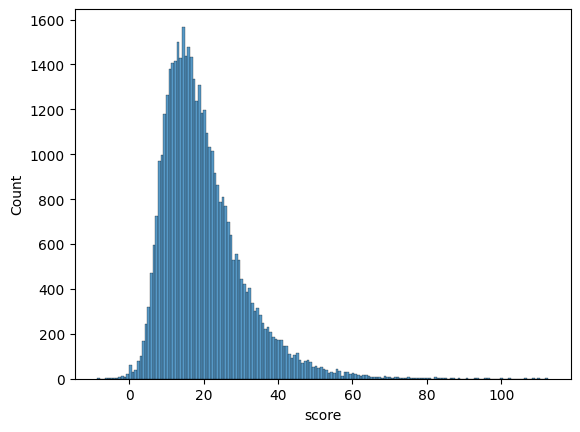

In [ ]:
sns.histplot(submit_data["score"])

In [ ]:
track_embeddings.shape, user_embeddings.shape

In [ ]:
gpu_res = faiss.StandardGpuResources()
index_flat = faiss.index_factory(track_embeddings.shape[1], "Flat", faiss.METRIC_L2)

#index = faiss.index_cpu_to_gpu(gpu_res, 0, index_flat)
index = index_flat
index.add(track_embeddings.astype('float32'))

In [ ]:
k = 100
with open("/gdrive/MyDrive/RecSys_Data/dssm_recs_faiss.json", "w") as rf:
    for user, user_emb in tqdm(zip(user_ids, user_embeddings), total=len(user_ids)):
      dists, neighbours = index.search(user_emb.astype('float32')[np.newaxis, :], k)
      recommendation = {
            "user": int(user),
            "tracks": neighbours.flatten().tolist()
        }
      rf.write(json.dumps(recommendation) + "\n")

  0%|          | 0/9783 [00:00<?, ?it/s]

Записываем эмбеддинги и логи обучения

In [ ]:
writer = tb.SummaryWriter(comment='ncf_embeddings', log_dir="/gdrive/MyDrive/RecSys_Data/Week5Seminar/tb")
writer.add_embedding(track_embeddings, metadata=list(track_metadata[["artist", "title"]].itertuples(index=False, name=None)), tag="DSSM", metadata_header=["artist", "title"])
writer.close()

In [ ]:
!cp -r /content/lightning_logs /gdrive/MyDrive/RecSys_Data/Week5Seminar/lightning_logs

In [ ]:
len([0, 1, 5, 59, 11, 768, 440, 4081, 16, 83, 2, 952, 4460, 78, 528, 55, 284, 486, 68, 2899, 556, 475, 464, 511, 390, 492, 314, 543, 405, 568, 4457, 84, 519, 479, 4363, 512, 500, 72, 415, 1189, 60, 2091, 482, 62, 545, 468, 1012, 3447, 494, 1126, 61, 542, 1111, 1697, 1123, 71, 4450, 66, 20, 142, 491, 77, 4961, 414, 1878, 508, 548, 736, 504, 3220, 441, 5724, 533, 498, 1616, 497, 517, 1682, 546, 532, 496, 4446, 2432, 549, 8405, 6602, 469, 2050, 473, 7139, 483, 563, 2000, 1366, 503, 3125, 1940, 1672, 552, 4210])

100